In [1]:
import random
from typing import Any

import numpy as np
from tqdm import tqdm
from rewards import rewards
from deap import base, creator, tools
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN

from visualization import plot_clusters_with_rewards, plot_agents_paths
import matplotlib.pyplot as plt

In [2]:
N_REWARDS = rewards.shape[0]
POP_SIZE = 180
BUDGET = 40
N_GEN = 400
CX_PROB = 0.9
MUT_PROB = 0.3
MUT_DECAY_RATE = N_GEN / 100

MAX_DISTANCE = 5
MIN_SAMPLES = 1
dbscan = DBSCAN(eps=MAX_DISTANCE / 2, min_samples=MIN_SAMPLES)
clusters = dbscan.fit_predict(rewards[:, :2]) 

distance_mx = cdist(rewards[:, :2], rewards[:, :2], metric="euclidean")

In [38]:
clusters

array([0, 1, 2, 0, 3, 4, 2, 3, 1, 3, 5, 5, 5, 6, 5, 5, 6, 7, 8, 9],
      dtype=int64)

<Axes: title={'center': 'Clusters com Recompensas'}, xlabel='Coordenada X', ylabel='Coordenada Y'>

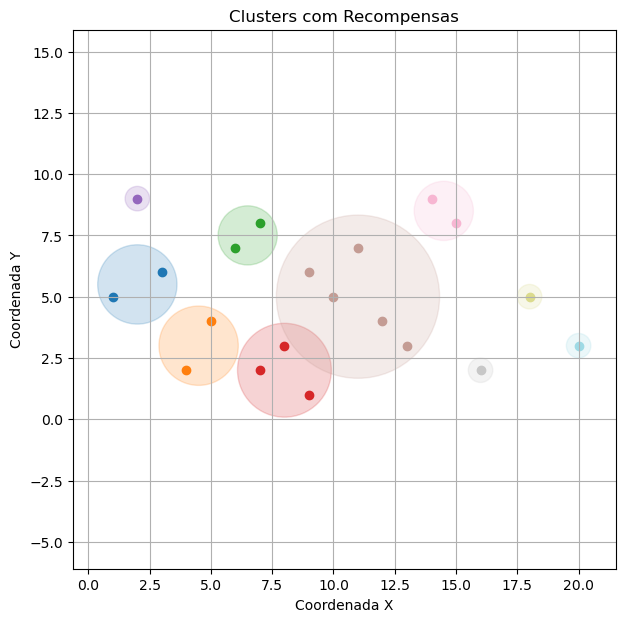

In [39]:
plot_clusters_with_rewards(rewards, clusters)

In [144]:
def init_individual(icls: Any) -> list:
    genes = [[], []]
    clusters_to_visit = np.unique(clusters)

    while len(genes[0]) < rewards.shape[0] and len(genes[1]) < rewards.shape[0]:
        cluster = np.random.choice(clusters_to_visit)
        cluster_points = np.where(clusters == cluster)[0]

        not_visited0 = cluster_points[~np.isin(cluster_points, genes[0])]
        not_visited1 = cluster_points[~np.isin(cluster_points, genes[1])]

        if len(not_visited0) == 0 or len(not_visited1) == 0:
            clusters_to_visit = clusters_to_visit[clusters_to_visit != cluster]
            continue

        num_points_to_visit = 1 if len(not_visited0) == 1 else np.random.randint(1, len(not_visited0))

        genes[0].extend(np.random.choice(not_visited0, size=num_points_to_visit, replace=False))
        genes[1].extend(np.random.choice(not_visited1, size=num_points_to_visit, replace=False))

    return icls(np.array(genes))


def cx_partially_matched(ind1: np.ndarray, ind2: np.ndarray) -> tuple:
    size = ind1.shape[1]
    p1, p2 = np.zeros(size, dtype=int), np.zeros(size, dtype=int)

    for i in range(size):
        p1[ind1[0][i]] = i
        p2[ind2[0][i]] = i

    cxpoint1 = random.randint(0, size - 1)
    cxpoint2 = random.randint(0, size - 1)
    if cxpoint2 < cxpoint1:
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1

    for i in range(cxpoint1, cxpoint2):
        temp1_path = ind1[:, i].copy()
        temp2_path = ind2[:, i].copy()

        ind1[:, i] = temp2_path
        ind2[:, i] = temp1_path

        ind1[:, p1[temp2_path[0]]] = temp1_path
        ind2[:, p2[temp1_path[0]]] = temp2_path

        p1[temp1_path[0]], p1[temp2_path[0]] = p1[temp2_path[0]].copy(), p1[temp1_path[0]].copy()
        p2[temp1_path[0]], p2[temp2_path[0]] = p2[temp2_path[0]].copy(), p2[temp1_path[0]].copy()

    return ind1, ind2


def mut_individual(individual: np.ndarray, indpb: float) -> tuple:
    print(individual)
    if np.random.random() < 0.5:
        mut_shuffle_idx(individual, indpb) 
        return

    path1, path2 = individual
    if np.random.random() < 0.5:
        mut_shuffle_idx_intra_cluster(path1, indpb)
    else:
        mut_shuffle_idx_intra_cluster(path2, indpb)
    return (individual,)


def mut_shuffle_idx(individual: np.ndarray, indpb: float) -> np.ndarray:
    for i in range(individual.shape[1]):
        if np.random.random() < indpb:
            mx_2 = np.random.randint(0, individual.shape[1])
            individual[:, i], individual[:, mx_2] = individual[:, mx_2].copy(), individual[:, i].copy()

    return (individual,)


def mut_shuffle_idx_intra_cluster(path: np.ndarray, indpb: float) -> np.ndarray:
    for i in range(len(path)):
        if np.random.random() < indpb:
            cluster = clusters[path[i]]
            cluster_points = np.where(clusters == cluster)[0]
            if len(cluster_points) > 1:
                mx_2 = np.random.choice(cluster_points)
                j = np.where(path == mx_2)[0][0]
                path[i], path[j] = path[j], path[i]

    return (path,)


def calculate_mutation_probability(generation: int, max_generations: int, initial_prob: float, decay_rate: float) -> float:
    return initial_prob * np.exp(-decay_rate * (generation / max_generations))


def eval_individual(individual: np.ndarray, distance_mx: np.ndarray) -> tuple:
    fitness = 0
    visited = set()

    for path in individual:
        total_distance = 0

        idx = path[0]
        if idx not in visited:
            fitness += rewards[idx, 2]
            visited.add(idx)

        distance_to_first_point = np.linalg.norm(rewards[idx, :2])
        if (total_distance + distance_to_first_point) > BUDGET:
            break
        total_distance += distance_to_first_point

        for i in range(1, len(path)):
            idx = path[i]
            distance = distance_mx[path[i - 1], idx]
            if (total_distance + distance) > BUDGET:
                break
            total_distance += distance

            if idx not in visited:
                fitness += rewards[idx, 2]
                visited.add(idx)

    return (fitness,)


creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("individual", init_individual, creator.Individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", cx_partially_matched)
toolbox.register("mutate", mut_individual, indpb=MUT_PROB)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", eval_individual, distance_mx=distance_mx)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

logbook = tools.Logbook()


def evolve():
    population = toolbox.population(n=POP_SIZE)
    for ind in population:
        ind.fitness.values = toolbox.evaluate(ind)

    record = stats.compile(population)
    logbook.record(gen=0, **record)

    for gen in tqdm(range(N_GEN), desc='Progress'):
        elite = tools.selBest(population, 1)[0]
        offspring = toolbox.select(population, len(population) - 1)
        offspring = list(map(toolbox.clone, offspring))

        for _ in range(len(offspring) // 2):
            parent1, parent2 = random.sample(offspring, 2)
            if np.random.random() < CX_PROB:
                toolbox.mate(parent1, parent2)
                del parent1.fitness.values
                del parent2.fitness.values
            
        mutation_prob = calculate_mutation_probability(gen, N_GEN, MUT_PROB, MUT_DECAY_RATE)
        for individual in offspring:
            if np.random.random() < mutation_prob:
                toolbox.mutate(individual)
                del individual.fitness.values

        for ind in offspring:
            ind.fitness.values = toolbox.evaluate(ind)

        offspring.append(elite)
        population[:] = offspring

        record = stats.compile(population)
        logbook.record(gen=0, **record)

    return tools.selBest(population, 1)[0], logbook

c:\Anaconda\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Anaconda\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [136]:
def check_clusters_sync(individual: np.ndarray, clusters: np.ndarray) -> bool:
    path1, path2 = individual

    if len(path1) != len(path2):
        return False

    for i in range(len(path1)):
        if clusters[path1[i]] != clusters[path2[i]]:
            return False

    return True

def has_duplicates(individual: np.ndarray) -> bool:
    path1 = individual[0]
    if len(path1) != len(set(path1)):
        return True
    
    path2 = individual[1]
    if len(path2) != len(set(path2)):
        return True
    
    return False

### Correctness Tests

In [ ]:
"""
Test Individual Initialization
"""

N_TESTS = 10000

error = 0 
duplicates = 0

for _ in tqdm(range(N_TESTS), desc='Progress'):
    individual = toolbox.individual()
    if not check_clusters_sync(individual, clusters):
        error += 1
    if has_duplicates(individual):
        duplicates += 1

if not error:
    print('No Errors Found')
else:
    print(error + ' errors found')

if not duplicates:
    print('No Duplicates Found')
else:
    print(duplicates + ' duplicates found')

Progress: 100%|██████████| 10000/10000 [00:37<00:00, 269.25it/s]

No Errors Found
No Duplicates Found


In [ ]:
"""
Test Mutation
"""

N_TESTS = 10000

error = 0 
duplicates = 0

individual = toolbox.individual()
for _ in tqdm(range(N_TESTS), desc='Progress'):
    toolbox.mutate(individual)
    if not check_clusters_sync(individual, clusters):
        error += 1
    if has_duplicates(individual):
        duplicates += 1

if not error:
    print('No Errors Found')
else:
    print(error, ' errors Found')

if not duplicates:
    print('No Duplicates Found')
else:
    print(duplicates, ' duplicates found')

Progress: 100%|██████████| 10000/10000 [00:00<00:00, 11778.32it/s]

No Errors Found


In [145]:
"""
Test Crossover
"""

N_TESTS = 10000

error = 0 
duplicates = 0

ind1 = toolbox.individual()
ind2 = toolbox.individual()
for _ in tqdm(range(N_TESTS), desc='Progress'):
    toolbox.mate(ind1, ind2)
    if not check_clusters_sync(ind1, clusters) or not check_clusters_sync(ind2, clusters):
        error += 1
    if has_duplicates(ind1) or has_duplicates(ind2):
        duplicates += 1

if not error:
    print('No Errors Found')
else:
    print(error, ' errors Found')

if not duplicates:
    print('No Duplicates Found')
else:
    print(duplicates, ' duplicates found')

Progress: 100%|██████████| 10000/10000 [00:00<00:00, 10461.16it/s]

No Errors Found
10000  duplicates found


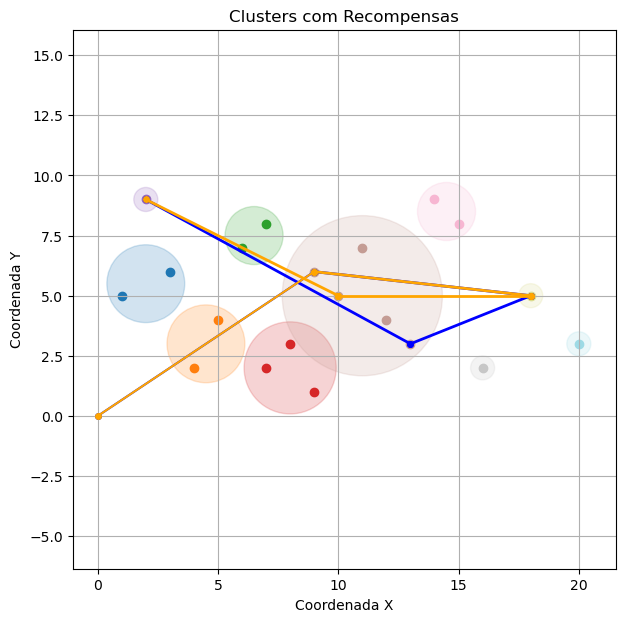

In [108]:
individual = toolbox.individual()
ax = plot_clusters_with_rewards(rewards, clusters)
plot_agents_paths(ax, rewards, individual, distance_mx, BUDGET)
plt.show()

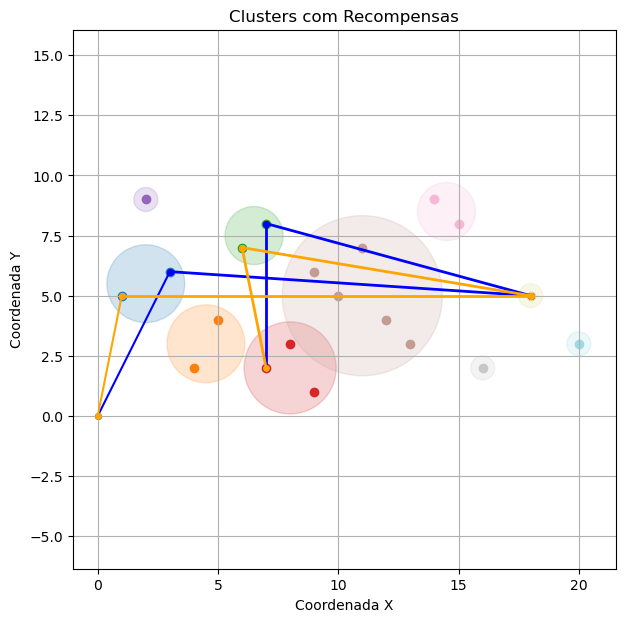

In [111]:
toolbox.mutate(individual)
ax = plot_clusters_with_rewards(rewards, clusters)
plot_agents_paths(ax, rewards, individual, distance_mx, BUDGET)
plt.show()

### Execution

In [135]:
best_individual, logbook = evolve()
ax = plot_clusters_with_rewards(rewards, clusters)
plot_agents_paths(ax, rewards, best_individual, distance_mx, BUDGET)

Progress:   0%|          | 0/400 [00:00<?, ?it/s]

[[ 7  4 16  6 15  2 13  5  3 12 18 19  1 17  8  9 14 11 10  0]
 [ 7  9 13  2 11  6 13  5  0 12 18 19  1 17  8  4 14 12 15  3]]
[[ 8  6  1  0  7  5 13 17  3  4  9  2 16 18 15 10 14 12 19 11]
 [ 1  2  8  3  4  5 13 17  0  9  7  6 13 18 12 15 14 11 19 10]]
[[16 13  9 10 12 15 14 19  2  1  0  3 11 18  5  8  6 17  7  4]
 [13 16  4 15 10 14 11 19  6  1  0  3 12 18  5  8  2 17  9  7]]
[[15  8 16 12  4  7  1  3  6 19 17  5 10  2 11 14  9 13  0 18]
 [12  1 16 14  7  9  1  3  6 19 17  5 11  2 15 15  4 16  0 18]]
[[15 10 18  0  5  9  3 19  6  8 14 12 17 13  1  2 11  7 16  4]
 [11 12 18  3  5  7  0 19  6  1 14 15 17 16  8  2 10  9 13  4]]
[[ 9  2  7  5  6 19 11 13  3 16 12 10 15  8 17  4  0  1 18 14]
 [ 4  2  7  5  6 19 14 16  0 13 10 12 15  8 17  7  3  1 18 11]]
[[16 13  9 10 12 15 14 19  2  1  0  3 11 18  5  8  6 17  7  4]
 [13 16  4 15 10 14 11 19  6  1  0  3 12 18  5  8  2 17  9  7]]
[[17 11 10 14 12 18  8  1 15  5 19 16 13  2  4  0  6  3  7  9]
 [17 15 11 15 10 18  8  1 14  5 19 16 13  2  7  

IndexError: index 0 is out of bounds for axis 0 with size 0